# Table of Contents
1. [Business Understanding](#Business-Understanding)

1. [Exploratory Data Analysis and Visualisation](#Exploratory-Data-Analysis)

1. [Churn Modelling](#Churn-Modelling)

    1. [Feature preprocessing](#Feature-preprocessing)
    1. [Churn prediction](#Churn-prediction)
    1. [Model tuning](#Model-tuning)
    
1. [Marketing campaign: 20% discount churned custormers](#Marketing-campaign:-20%-discount-churned-customers)


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

random_state = np.random.RandomState(1)
np.random.seed(1) # for reproducibility

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 5)

In [3]:
import os

In [4]:
os.chdir('../data')

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## SME Features (January 2016)

In [95]:
dates = ['contract_activation_date',
         'contract_end_date',
         'contract_fist_act_date',
         'contract_last_mod_date',
         'contract_renewal_date']

In [32]:
train_data = pd.read_csv('aily_case_training_data.csv',index_col='contract_id', parse_dates=dates)
train_data.head()

,company_category,campaing_code_elect,channel,elect_cons_at_12m,gas_cons_at_12m,elect_cons_last_month,contract_activation_date,contract_end_date,contract_fist_act_date,contract_last_mod_date,...,fcst_price_power_period_1,client_got_gas,current_paid_consumption,gross_margin_power_elect,net_margin_power_elect,number_active_products,total_net_margin,customer_antiquity_in_years,code_elect_campaign_first_subs,subscribed_power
contract_id,,,,,,,,,,,,,,,,,,,,,
d07d473503c6bef7cf1922fab1f88f3e,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1577,0,0,2010-01-05,2016-12-12,NaT,2015-11-01,...,29.744311,f,0.000000,40.484555,36.606656,1,9.790569,6,lxidpiddsbxsbosboudacockeimpuepw,13.009751
79e38c743a89ad6b950ae6136bbaeb2b,ixuciffexbsibwibpcwdmfwcoixkfscw,NaN,foosdfpfkusacimwkcsosbicdxkicaua,280731,0,16856,2009-11-04,2016-11-04,NaT,2009-11-04,...,27.257522,f,1440.595633,-28.777615,-26.021090,1,872.951153,6,lxidpiddsbxsbosboudacockeimpuepw,125.190059
6f6a16ed39fd75715b1acc656c749f83,fmwdwsxillemwbbwelxsampiuwwpcdcb,NaN,foosdfpfkusacimwkcsosbicdxkicaua,99223,189585,4783,2013-02-16,2016-02-16,NaT,2013-02-16,...,27.257522,t,0.000000,61.939503,56.006496,2,55.939033,3,lxidpiddsbxsbosboudacockeimpuepw,19.949036
1d8e17bf13218e671e968871e0c6373f,afeccskfmobewicibxofslkxecsuekfi,NaN,foosdfpfkusacimwkcsosbicdxkicaua,10381,0,0,2012-01-25,2017-01-25,NaT,2015-12-16,...,27.257522,f,0.000000,94.215208,85.190604,2,53.813449,4,lxidpiddsbxsbosboudacockeimpuepw,30.356086
2c195164c61eeb0edee79688790f3dda,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,6107,0,0,2011-11-12,2016-11-12,2011-11-12,2015-09-20,...,31.082797,f,0.000000,43.562873,39.390111,1,11.044119,4,lxidpiddsbxsbosboudacockeimpuepw,17.338823


In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, d07d473503c6bef7cf1922fab1f88f3e to 5844cbd329236f04d75b25d68a7ab279
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   company_category                     6551 non-null   object        
 1   campaing_code_elect                  0 non-null      float64       
 2   channel                              11878 non-null  object        
 3   elect_cons_at_12m                    16096 non-null  int64         
 4   gas_cons_at_12m                      16096 non-null  int64         
 5   elect_cons_last_month                16096 non-null  int64         
 6   contract_activation_date             16096 non-null  datetime64[ns]
 7   contract_end_date                    16094 non-null  datetime64[ns]
 8   contract_fist_act_date               3508 non-null   datetime64[ns]
 9   contract_last_mod_date        

Let's keep variables with relative small number of NaN values

In [96]:
train_data = train_data[train_data.columns[train_data.isna().sum() < 200]]

In [113]:
len(list(train_data.columns))

23

Let's select numeric variables so that we can inspect their distribution.

In [97]:
numerics = ['int64', 'float64']
train_data_num = train_data.select_dtypes(include=numerics)

In [98]:
list(train_data_num.columns)

['elect_cons_at_12m',
 'gas_cons_at_12m',
 'elect_cons_last_month',
 'fcst_consumption_elect_12m',
 'fcst_consumption_elect_cal_year',
 'fcst_current_discount',
 'fcst_bill_meter_rent_12m',
 'fcst_price_period_1',
 'fcst_price_period_2',
 'fcst_price_power_period_1',
 'current_paid_consumption',
 'gross_margin_power_elect',
 'net_margin_power_elect',
 'number_active_products',
 'total_net_margin',
 'customer_antiquity_in_years',
 'subscribed_power']

/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/isabel/anaconda3/envs/AilyLabs/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

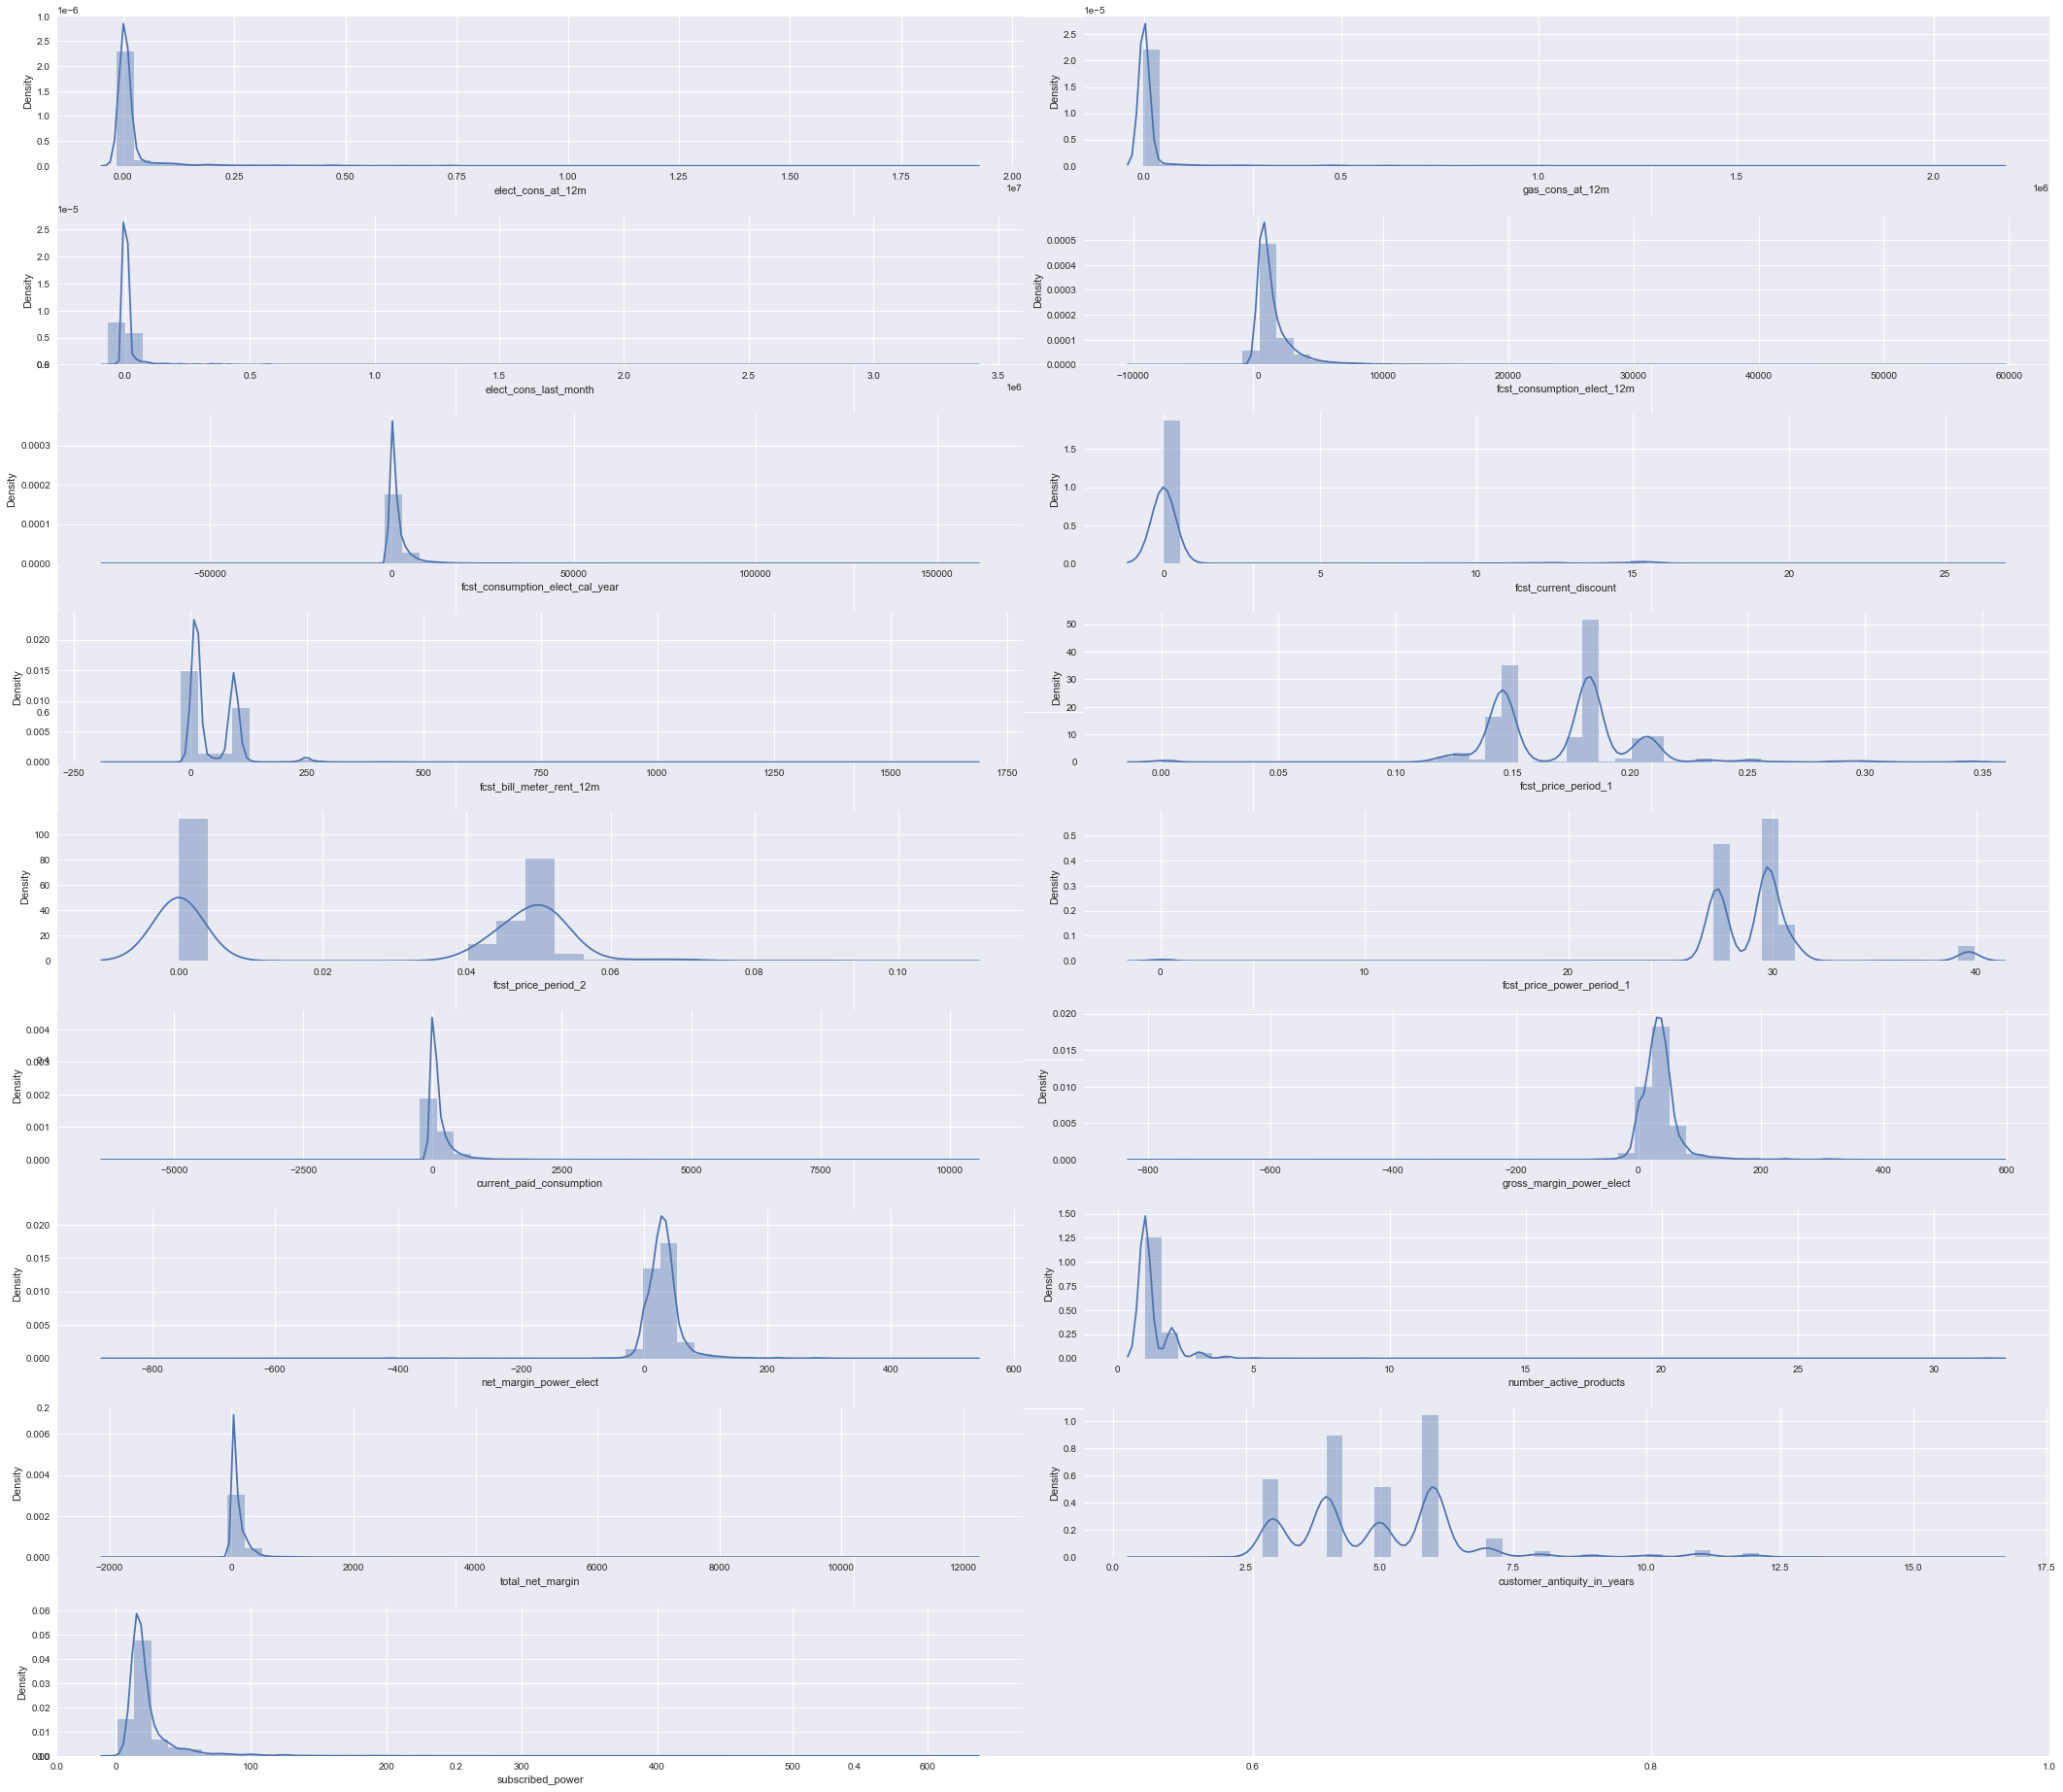

In [67]:
fig, ax = plt.subplots(figsize = (30, 26))
for i, col in enumerate(train_data_num.columns):
    ax=fig.add_subplot(9, 2, i+1)
    sns.distplot(train_data_num[col],ax=ax)
plt.tight_layout()

## Energy and Power prices (2015)

In [99]:
train_data_hist = pd.read_csv('aily_case_training_hist_data.csv',
                              parse_dates=['reference_date'],
                              index_col='contract_id')
train_data_hist.head()

,reference_date,price_energy_1st_period,price_energy_2nd_period,price_energy_3rd_period,price_power_1st_period,price_power_2nd_period,price_power_3rd_period
contract_id,,,,,,,
cd7ad4a23c39fd588bf326333786300c,2015-02-01,0.136157,0.000000,0.0,39.926856,0.0,0.0
73c63df734c0948948b61dcab3153dce,2015-06-01,0.134560,0.000000,0.0,39.926855,0.0,0.0
75d7981514dd168b8ca9954c62342426,2015-03-01,0.153324,0.067422,0.0,39.926856,0.0,0.0
3d4e8ae29da9e25cf77dd6966ff8c02e,2015-09-01,0.133067,0.000000,0.0,39.926855,0.0,0.0
5c8b795e6ff043528535ef4060416db3,2015-04-01,0.137101,0.000000,0.0,39.926855,0.0,0.0


Let's drop Na's.

In [70]:
train_data_hist = train_data_hist.dropna()

In [71]:
train_data_hist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191643 entries, cd7ad4a23c39fd588bf326333786300c to 7d75ec3494d3f99080dfb8cb173c5b90
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   reference_date           191643 non-null  datetime64[ns]
 1   price_energy_1st_period  191643 non-null  float64       
 2   price_energy_2nd_period  191643 non-null  float64       
 3   price_energy_3rd_period  191643 non-null  float64       
 4   price_power_1st_period   191643 non-null  float64       
 5   price_power_2nd_period   191643 non-null  float64       
 6   price_power_3rd_period   191643 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 11.7+ MB


In [72]:
train_data_hist.describe()

,price_energy_1st_period,price_energy_2nd_period,price_energy_3rd_period,price_power_1st_period,price_power_2nd_period,price_power_3rd_period
count,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000,191643.000000
mean,0.127477,0.043164,0.039137,39.077768,8.084069,4.893413
std,0.022710,0.039691,0.046303,4.904798,9.714639,5.899199
min,0.000000,0.000000,0.000000,-0.160349,-0.073866,-0.049402
25%,0.113901,0.000000,0.000000,36.735692,0.000000,0.000000
50%,0.132036,0.067813,0.000000,39.926855,0.000000,0.000000
75%,0.137101,0.080741,0.092463,40.087205,18.392143,12.300087
max,0.253795,0.182288,0.145403,53.616556,27.574100,13.233853


Let's draw multiple lineplots.

In [108]:
energy_melted = pd.melt(train_data_hist, id_vars='reference_date',
                 value_vars=['price_energy_1st_period', 'price_energy_2nd_period', 'price_energy_3rd_period'])

In [110]:
power_melted = pd.melt(train_data_hist, id_vars='reference_date',
                 value_vars=['price_power_1st_period', 'price_power_2nd_period', 'price_power_3rd_period'])

<AxesSubplot:xlabel='reference_date', ylabel='value'>

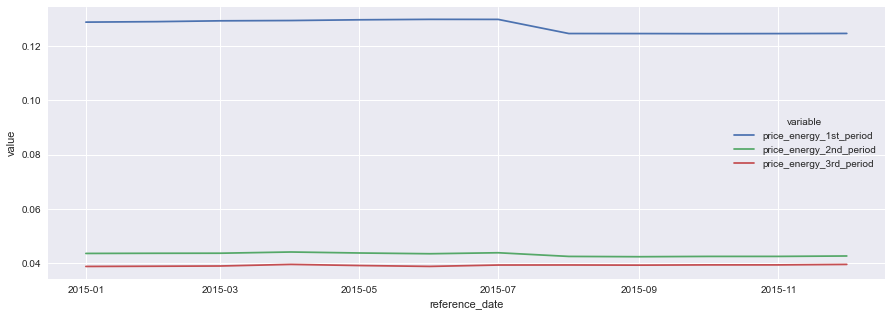

In [109]:
sns.lineplot(x='reference_date', y='value', hue='variable', data=energy_melted, ci=None)

<AxesSubplot:xlabel='reference_date', ylabel='value'>

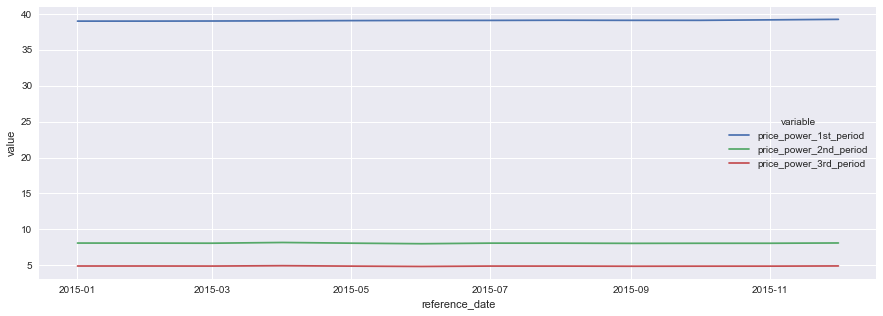

In [111]:
sns.lineplot(x='reference_date', y='value', hue='variable', data=power_melted, ci=None)

In [125]:
train_data_hist = train_data_hist.groupby('contract_id').mean()

## Churned customers after a period of 3 months (March 2016)

In [92]:
train_data_output = pd.read_csv('aily_case_training_output.csv', index_col='contract_id')
train_data_output.head()

,has_churned_over_next_3m
contract_id,
6975aab29f35173b43eae4f595b747c7,0
8073016b742f47cf4c76cc41dc410122,1
227c0e6b15256a1d3d3460e15c24ba60,0
e1ea0597bbad7bfd95adf1c7103bfda1,0
a2e017f297f2557a7b1cf4a92bc993e9,0


In [90]:
train_data_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   contract_id               16096 non-null  object
 1   has_churned_over_next_3m  16096 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 251.6+ KB


In [91]:
churn_count = train_data_output.groupby('has_churned_over_next_3m').count()
churn_count

,contract_id
has_churned_over_next_3m,
0,14501
1,1595


## Unified dataset

join dataset

In [131]:
join = train_data_output.merge(train_data, on='contract_id', how='left')

In [132]:
dataset = join.merge(train_data_hist, on='contract_id', how='left')

In [129]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16096 entries, 6975aab29f35173b43eae4f595b747c7 to 47204237e076a43d4e60da4bccd05587
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   has_churned_over_next_3m         16096 non-null  int64         
 1   elect_cons_at_12m                16096 non-null  int64         
 2   gas_cons_at_12m                  16096 non-null  int64         
 3   elect_cons_last_month            16096 non-null  int64         
 4   contract_activation_date         16096 non-null  datetime64[ns]
 5   contract_end_date                16094 non-null  datetime64[ns]
 6   contract_last_mod_date           15939 non-null  datetime64[ns]
 7   contract_renewal_date            16056 non-null  datetime64[ns]
 8   fcst_consumption_elect_12m       16096 non-null  float64       
 9   fcst_consumption_elect_cal_year  16096 non-null  float64       
 10  fcst_

In [144]:
dataset = dataset.reset_index().drop(columns=['contract_id', 'has_churned_over_next_3m'])

In [146]:
dataset.head()

,elect_cons_at_12m,gas_cons_at_12m,elect_cons_last_month,contract_activation_date,contract_end_date,contract_last_mod_date,contract_renewal_date,fcst_consumption_elect_12m,fcst_consumption_elect_cal_year,fcst_current_discount,...,total_net_margin,customer_antiquity_in_years,code_elect_campaign_first_subs,subscribed_power,price_energy_1st_period,price_energy_2nd_period,price_energy_3rd_period,price_power_1st_period,price_power_2nd_period,price_power_3rd_period
0,12067,8723,303,2009-08-21,2016-08-21,2015-07-10,2015-08-22,395.464648,368.851331,0.000000,...,37.220019,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,21.595285,0.110674,0.080749,0.092049,36.637731,18.416764,12.316552
1,3183,0,406,2011-12-19,2016-12-19,2015-11-01,2015-12-21,228.789150,494.224444,0.000000,...,17.946074,4,lxidpiddsbxsbosboudacockeimpuepw,15.648757,0.134979,0.000000,0.000000,39.966943,0.000000,0.000000
2,18464,26847,1534,2010-01-20,2016-06-04,2015-06-04,2015-01-22,1096.439754,1863.335174,15.460479,...,57.147990,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,21.595285,0.135881,0.098951,0.112162,36.850767,18.611662,12.520295
3,17743,0,0,2012-03-12,2016-03-12,2012-03-12,2015-03-13,1270.888652,0.000000,0.000000,...,105.174300,4,lxidpiddsbxsbosboudacockeimpuepw,16.462493,0.134149,0.000000,0.000000,40.047118,0.000000,0.000000
4,42537,7606,3873,2012-07-12,2016-09-20,2013-09-20,2015-09-25,2006.504608,4703.308727,0.000000,...,185.465888,4,lxidpiddsbxsbosboudacockeimpuepw,31.418949,0.108842,0.079142,0.089469,36.637731,18.416764,12.316552


<AxesSubplot:>

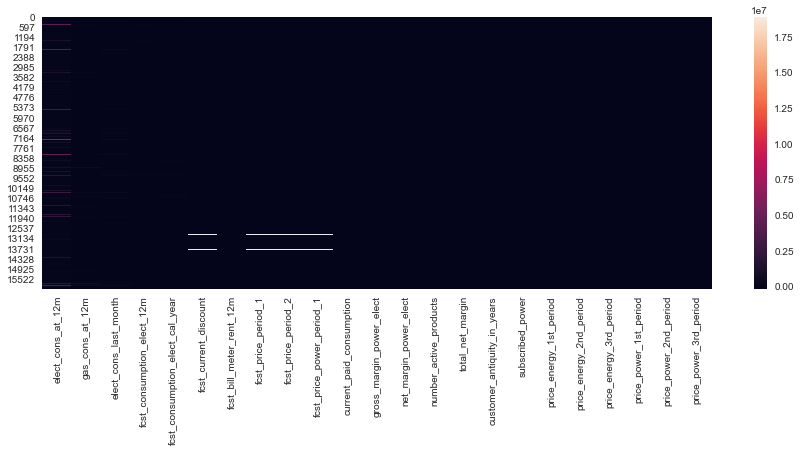

In [145]:
sns.heatmap(dataset.select_dtypes(exclude=['datetime64[ns]', 'object']))